In [1]:
# Adapting the 1DHT model from Hornum et al. (2020) from MATLAB to Python

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time

In [113]:
#      Constants and general model setup
toyr =60*60*24*365     # to year from s

            # Thermal properties of water and ice (from Williams and Smith, 1989) %%%
            
p_w = 1000             # density [kg/m3]
p_ice = 917
cp_w = 4180            # specific heat capacity [J/(kg*K)]
cp_ice = 2100
k_w = 0.56*toyr        # thermal conductivity [(J/yr)/(m K)]
k_ice = 2.24*toyr
L=333.6*1000           # Latent heat of fusion [J/kg]

p_w = 1000
cp_w = 4180
k_w = 0.56 * toyr

#Julie paper — not using these right now, but maybe implement them later when we want to change matrix percentages

#p_ice = 917
#cp_ice = 185 + 7.037*T
#k_ice = (0.4685 + (488.12/T)) * toyr
#L=333.6*1000  

p_hyd = 1000
cp_hyd = 494 + (6.1*150)
k_hyd = 0.64 * toyr

p_salt = 2200
cp_salt = 920
k_salt = 0.6 * toyr

p_rock = 2430
cp_rock = 2000
k_rock = 0.56 * toyr


            ## Porosity and thermal properties of CERES materials ##
            
n_Sc=0                 # Porosity scenario is chosen here: 1=minimum n, 2=intermediate n, 3=maximum n
nLob=[0.33, 0.5, 0.66]    ## [min interm. max] Lobate (thermal model; 6B) ##


                    ### Material 1 - Lobate
#start with 40% ice, 25% hydrates, 20% rock, 15% salts
nL = nLob[n_Sc]        
p_soilL = 1300       ## DENSITY (thermal model; 2B)             
cp_soilL = 1538.46       ## HEAT CAPACITY; GRAB FROM JULIE'S DATABASE (this is going to be tricky with temperature dependence)    
k_soilL = 1.27*toyr   ## THERMAL CONDUCTIVITY; GRAB FROM JULIE'S DATABASE (20% ice, 45% hydrates)       
aQ=k_soilL/(p_soilL*cp_soilL) #THERMAL DIFFUSIVITY [m^2/yr]
pcp = [2e6, 14e6, 4e6] #average effective heat capacity for 150<T<245, 245<T<273, and 273<T<300 K, respectively


            ### Model parameters ###
tstep=0.05         # time step [yr] this is the minimum time step with our material properties
ts_1yr=1/tstep     # number of time steps in a year; 20
dz=2               # cell size [m]
grid_depth=600     ## grid depth, GRID SPANS 600m (depth of lobate flow) (domain constraints; 5B)
z=np.arange(0,grid_depth+dz,dz) # cell nodes, 0,2,4,6 M ETC.
nocell=len(z)    # number of cells
print(nocell)

301


In [114]:
 ### Temperature ###
Kv= -273.15              # set to -273.15 if in Kelvin. 0 if in C
T_gradient=0.00273    ## Thermal gradient [K/m] (Raymond et al. 2020) (thermal model; 7B)
T_0=273           # Initial surface temperature - NOT USED if temperature reconstruction is defined
T_end=350 # Initial temperature at bottom of grid - NOT USED in for loop (estimate from Bowling)
T_ini_1=np.zeros(nocell) # Initial temperature distribution, gives every cell node a temperature
for i in range(len(T_ini_1)):
    if 0 <= i < 2:
        T_ini_1[i] = 150.00
    elif 2 <= i < (nocell-1)/2:
        T_ini_1[i] = (((300.15-150)/(300))*z[i]) + 150
    elif i == (nocell-1)/2:
        T_ini_1[i] = 300.15
    elif i > (nocell-1)/2:
        T_ini_1[i] = (((150-300.15)/300)*z[i-150]) + 300.15
    elif i == grid_depth-1:
        T_ini_1[i] = 150.00
    #else:
    #    T_ini_1[i] = 300
    #else:
        #T_ini_1[i] = 300

T_ini = [round(item, 2) for item in T_ini_1] #rounding all floats to the nearest hundredth to match with interpolated SFC
print(T_ini)

[150.0, 150.0, 152.0, 153.0, 154.0, 155.0, 156.01, 157.01, 158.01, 159.01, 160.01, 161.01, 162.01, 163.01, 164.01, 165.02, 166.02, 167.02, 168.02, 169.02, 170.02, 171.02, 172.02, 173.02, 174.02, 175.02, 176.03, 177.03, 178.03, 179.03, 180.03, 181.03, 182.03, 183.03, 184.03, 185.04, 186.04, 187.04, 188.04, 189.04, 190.04, 191.04, 192.04, 193.04, 194.04, 195.04, 196.05, 197.05, 198.05, 199.05, 200.05, 201.05, 202.05, 203.05, 204.05, 205.06, 206.06, 207.06, 208.06, 209.06, 210.06, 211.06, 212.06, 213.06, 214.06, 215.06, 216.07, 217.07, 218.07, 219.07, 220.07, 221.07, 222.07, 223.07, 224.07, 225.08, 226.08, 227.08, 228.08, 229.08, 230.08, 231.08, 232.08, 233.08, 234.08, 235.08, 236.09, 237.09, 238.09, 239.09, 240.09, 241.09, 242.09, 243.09, 244.09, 245.09, 246.1, 247.1, 248.1, 249.1, 250.1, 251.1, 252.1, 253.1, 254.1, 255.1, 256.11, 257.11, 258.11, 259.11, 260.11, 261.11, 262.11, 263.11, 264.11, 265.12, 266.12, 267.12, 268.12, 269.12, 270.12, 271.12, 272.12, 273.12, 274.12, 275.12, 276.13,

In [115]:
# Ceres temperature reconstruction (just a .txt file) with 100k rows each with a temp of 150 K
# Load the data from the text file
TCurve_data = pd.read_csv('cerestempcurve.txt', header=None)

T_ann10 = TCurve_data[1] #temperatures, dep variable
tt_yr = TCurve_data[0] #years, indep variable

ttt = np.arange(0, 100000+tstep, tstep) #do this for maximum runtime, can filter down later
interp_function = interp1d(tt_yr, T_ann10, kind='linear', fill_value='extrapolate')

T_ann10q = interp_function(ttt) #interpolating the surface temperature so there is one for every time step

print(T_ann10q[-1])

150.0


In [116]:
### Assigning material IDs to the different model grids and creating empty vectors and matrices. ###
### For now, we are only doing one column and one material ID (lobate) ###

# 1=Lobate
onegrid=np.ones(nocell) # 1 x 301 matrix

                # Material IDs ZONEs 2-3 (3), 1-2 (2), 0-1 (1)
Z0_1MatID=np.ones(nocell)
Z0_1MatID[0]=3 #let's set the carapace to just ice
Z0_1MatID[1]=3

            ### Creating one-vectors and empty matrices used in for-loop ###
n_grid=np.ones(nocell) # all of these have nocell elements -> all material properties define at nodes (1 x nocell matrix)
p_soil=np.ones(nocell)
cp_soil=np.ones(nocell)
k_soil=np.ones(nocell)

df_w=np.zeros(nocell-1) ## CHANGE IN fraction of water in pore space
k_eq=np.zeros(nocell-1) ## EQUIVALENT THERMAL CONDUCTIVITY
C_eq=np.zeros(nocell)   ## EQUIVALENT HEAT CAPACITY
a_eq=np.zeros(nocell)   ## EQUIVALENT THERMAL DIFFUSIVITY

runtime = 1000

T_matx_0_1=np.zeros((nocell,runtime)) ### CREATING EMPTY TEMP MATRICES FOR EACH ZONE'S RUN TIME (100000 yr)
#T_matx_0_1[:,0] = T_ini.copy()                                    ### add more as needed

f_matx_0_1=np.zeros((nocell,runtime)) # NOT SURE WHAT F MEANS, IS THIS FRACTION OF WATER OF EACH CELL IN EACH ZONE?
#F_matx_0_1[:,0] = F_ice.copy()

w=0.957725     # Correction factor, DESCRIBED IN SECTION 4.1 IN PAPER, T_S = -2 ºC, T_L = 0 ºC

In [135]:
### Numerical Model ###
### Only writing for one column ###

col_incl=[1]       ### Specify which of the 12 columns (zones) to include in the ground temperature simulation (e.g. [1:12] (all), [4] (only one), [1 5 11] (several specific ones).
for col in col_incl:
    if col==1:            ### Defining the column in use
        runtime=1000      # Simulation runtime
        materialid=Z0_1MatID

for ii in range(nocell): #applying material properties to each cell in the domain
    if materialid[ii] == 1:
        n_grid[ii] = onegrid[ii] * nL
    if materialid[ii] == 1:
        p_soil[ii] = onegrid[ii] * p_soilL
    if materialid[ii] == 1:
        cp_soil[ii] = onegrid[ii] * cp_soilL
    if materialid[ii] == 1:
        k_soil[ii] = onegrid[ii] * k_soilL
    if materialid[ii] == 2:
        n_grid[ii] = onegrid[ii] * nL
    if materialid[ii] == 2:
        p_soil[ii] = onegrid[ii] * ((0.56*p_hyd)+(0.25*p_rock)+(0.19*p_salt)) #linear combination, not super accurate, just playing around
    if materialid[ii] == 2:
        cp_soil[ii] = onegrid[ii] * ((0.56*cp_hyd)+(0.25*cp_rock)+(0.19*cp_salt))
    if materialid[ii] == 2:
        k_soil[ii] = onegrid[ii] * ((0.56*k_hyd)+(0.25*k_rock)+(0.19*k_salt))
    if materialid[ii] == 3:
        n_grid[ii] = onegrid[ii] * nL
    if materialid[ii] == 3:
        p_soil[ii] = onegrid[ii] * p_ice
    if materialid[ii] == 3:
        cp_soil[ii] = onegrid[ii] * cp_ice
    if materialid[ii] == 3:
        k_soil[ii] = onegrid[ii] * k_ice

no_tstep = int(runtime / tstep)  # Total number of time steps, DIFFERENT FOR EACH ZONE

T_11 = T_ann10q[:no_tstep + 1]  # Cutting temperature curve to simulation period
T_1 = np.flip(T_11)  # New T_1 #This is just 150 K for each time step

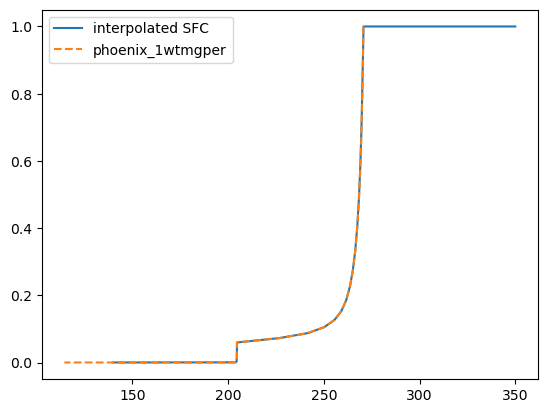

In [136]:
# reading in SFC, creating interpolated pore water fractions from input temp array and SFC

phoenix_1wtmgper = pd.read_csv('/Users/alexiakubas/Desktop/Ceres/1DHT_clone/-1DHT-model-code/SFCs/phoenix_1wtmgper.txt', header=None)
fw4 = phoenix_1wtmgper[1] #liquid fraction in the pore space, Sl = 1- Si, dep variable
temp4 = -1*phoenix_1wtmgper[0] #degrees celsius, indep variable
temp4 = temp4 + 273.15 #converted temperatures to Kelvin

interp_temps = np.arange(140, 350, 0.01)
interp_fw = interp1d(temp4, fw4, kind='linear', fill_value='extrapolate')
SFC_fw = interp_fw(interp_temps)

for i in range(len(SFC_fw)): #manually set fw at 1 for all cells above freezing
    if SFC_fw[i] >= 1:
        SFC_fw[i] = 1
        
plt.plot(interp_temps, SFC_fw, label='interpolated SFC')
plt.plot(temp4, fw4, label='phoenix_1wtmgper', linestyle='dashed')
#plt.ylim(-0.1,1.1)
plt.legend()

In [137]:
# Function to get fw for an input temperature

def get_fw(temp):
    indices = np.where(np.isclose(interp_temps, temp, atol=0.005))[0] #gets index for initial temp value in interp_temp
    index = indices[0] #in case there are multiple indices
    f_w_value = SFC_fw[index]
    return(f_w_value)

In [138]:
# Assign initial F_w, F_ice, f_w, and f_ice values for the model domain given the initial temperature.
# I want to match the initial temperature to whatever index it is in interp_temps, grab the value of
# that same index in SFC_fw, and set that value as the initial f_w

#for this to work, needs to be the last cell before model begins (i.e., all material properties must be set before this)

# First, initialize the fraction arrays
F_w = np.zeros((nocell, no_tstep))
F_ice = np.zeros((nocell, no_tstep))
f_w = np.zeros((nocell, no_tstep))
f_ice = np.zeros((nocell, no_tstep))
F_soil = np.zeros((nocell, no_tstep))

# assign values to f_w first, since this is info from SFC
for i in range(len(T_ini)): #len(T_ini) = nocell
    f_w[i,0] = get_fw(T_ini[i])

#using f_w values, assign initial values of other fraction arrays
for i in range(nocell):
    f_ice[i,0] = 1 - f_w[i,0]
    F_w[i,0] = f_w[i,0] * n_grid[i]
    F_ice[i,0] = n_grid[i] - F_w[i,0]
    F_soil[i,0] = 1 - n_grid[i]
    
#The top and bottom cells are excluded from model runs, so we need to prescribe fractions to them
f_w[0,:]=0
f_w[-1,:]=1
#F_w=onegrid
F_w[0,:]=0
f_ice[0,:]=1
f_ice[-1,:]=0
F_ice[-1,:]=0

In [139]:
print(f_w[:,0])

[0.00000000e+00 1.12761294e-04 1.13479089e-04 1.13837987e-04
 1.14196884e-04 1.14555782e-04 1.14918269e-04 1.15277166e-04
 1.15636064e-04 1.15994961e-04 1.16353859e-04 1.16712757e-04
 1.17071654e-04 1.17430552e-04 1.17789449e-04 1.18151936e-04
 1.18510834e-04 1.18869731e-04 1.19228629e-04 1.19587526e-04
 1.19946424e-04 1.20305322e-04 1.20664219e-04 1.22583751e-04
 1.24571565e-04 1.26559380e-04 1.28567073e-04 1.30554888e-04
 1.32542703e-04 1.34530518e-04 1.36518333e-04 1.38506148e-04
 1.40493962e-04 1.42481777e-04 1.44469592e-04 1.47262607e-04
 1.51103467e-04 1.54944328e-04 1.58785188e-04 1.62626048e-04
 1.66466909e-04 1.70307769e-04 1.74148629e-04 1.80437912e-04
 1.88479959e-04 1.96522005e-04 2.04644472e-04 2.13233144e-04
 2.28707990e-04 2.44182836e-04 2.63628822e-04 2.95699566e-04
 3.40070856e-04 4.34320982e-04 9.30454704e-04 5.99423160e-02
 6.05158558e-02 6.10893955e-02 6.16629353e-02 6.22364750e-02
 6.28100148e-02 6.33835545e-02 6.39570943e-02 6.45306341e-02
 6.51041738e-02 6.567771

In [140]:
### stability criterion ###
# calculates the effective thermal diffusivity of the soil and ice material
# if stability < 0.5, model will proceed

k_s_ice = ((n_grid * np.sqrt(k_ice)) + ((1-n_grid) * np.sqrt(k_soil))) ** 2
C_s_ice = (n_grid * p_ice * cp_ice) + ((1 - n_grid) * p_soil * cp_soil)
a_s_ice = k_s_ice / C_s_ice
stability = (np.max(a_s_ice) * tstep / dz**2)
print(stability)

0.45853871319520145


In [141]:
#temperature array used in numerical model

T = np.zeros((nocell, no_tstep))
T[:, 0] = T_ini.copy()

print(T)
T.shape

[[150.   0.   0. ...   0.   0.   0.]
 [150.   0.   0. ...   0.   0.   0.]
 [152.   0.   0. ...   0.   0.   0.]
 ...
 [152.   0.   0. ...   0.   0.   0.]
 [151.   0.   0. ...   0.   0.   0.]
 [150.   0.   0. ...   0.   0.   0.]]


(301, 20000)

In [142]:
xT_ini = np.copy(T_ini)
#print(xT_ini)

val = get_fw(xT_ini[5])
print(val)

0.00011455578205773222


In [143]:
### Numerical Model ###
### heat transfer loop starts

#I think I need to make the fractional arrays multidimensional so that there is a fraction for each cell for each time step or something

start_time = time.time()
if col==1:
    xT_ini = np.copy(T_ini)
    k = 0 #time step count
    l = 0 #year count
    for t in range(no_tstep):
        if stability > 0.5:
            break
        k += 1
        for i in range(1, nocell-1): #excluding top and bottom bc they have prescribed fractions
            f_w[i,k] = get_fw(xT_ini[i])
            f_ice[i,k] = 1 - f_w[i,k]
            
            #not sure how to handle this next block of code with new freezing curve
            if xT_ini[i] < 271.15:
                df_w[i] = 0
            elif xT_ini[i] > 273.15:
                df_w[i] = 0
            else:
                df_w[i] = -2 * xT_ini[i] * np.exp(-(xT_ini[i] / w) ** 2)  # diff of eq. A — leave this for now
            
            F_w[i,k] = f_w[i,k] * n_grid[i]
            F_ice[i,k] = f_ice[i,k] * n_grid[i]

            #calculating equivalent material properties
            k_eq[i] = ((F_soil[i,k] * np.sqrt(k_soil[i])) + (f_w[i,k] * np.sqrt(k_w)) + (f_ice[i,k] * np.sqrt(k_ice))) ** 2
            C_eq[i] = (F_soil[i,k] * p_soil[i] * cp_soil[i]) + (f_w[i,k] * p_w * cp_w) + (f_ice[i,k] * p_ice * (cp_ice + L * df_w[i]))
            a_eq[i] = k_eq[i] / C_eq[i]

            if (xT_ini[i + 1] - xT_ini[i - 1]) != 0:
                T[i, t] = (((a_eq[i]*tstep)/dz**2) * (xT_ini[i + 1] + xT_ini[i - 1])) + (xT_ini[i] * (1 - ((2*a_eq[i]*tstep)/dz**2)))
            else:
                T[i, t] = xT_ini[i]
            
            T[0, t] = T_1[t] #setting the top boundary to 150 K
            T[nocell - 1, t] = T[nocell - 2, t] + dz * T_gradient #this can be changed to whatever we want the bottom boundary to be
            
        xT_ini = T[:, t]      ### Value used in loop
                
        a_eq_0_1=np.copy(a_eq)      ### Vectors for figures         <<<<<<<<<<<<<<<--------------------
        C_eq_0_1=np.copy(C_eq)
        f_w_0_1=np.copy(f_w[:,k])
        f_ice_0_1=np.copy(f_ice[:,k])
        
         ### Creating a matrix with the temperature distribution for each year
        if k==ts_1yr: # IF ALL TIME STEPS WERE COMPLETED IN ONE YEAR,
            if l != runtime:
                ## UPDATES THE MATRICES FOR EACH COLUMN: ONE TEMP PER CELL PER YEAR
                # updates column of T matrix w temps from time step
                T_matx_0_1[:,l]=T[:,t].copy()     ### Vectors for figures         <<<<<<<<<<<<<<<--------------
                f_matx_0_1[:,l]=f_w[:,k].copy()
                l+=1 # INCREASE TO NEXT YEAR
                k=0
            elif l == runtime:
                l += 1
                k = 0
print('complete')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

complete
Elapsed time: 503.4344310760498 seconds


In [144]:
T.shape #should be nocell x no_tstep

(301, 20000)

In [145]:
T_matx_0_1.shape #should be nocell x runtime

(301, 1000)

In [146]:
f_w.shape

(301, 20000)

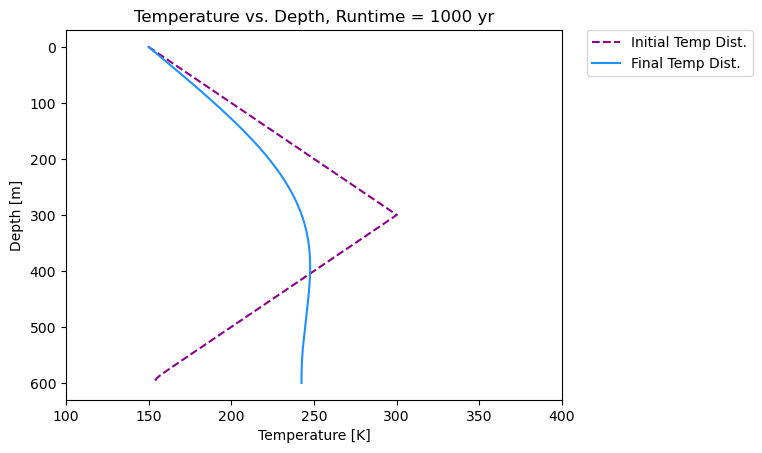

In [147]:
### Fig - Final temperature distrubution
#plotting curves for initial and final temp distributions

plt.xlim([100,400])
plt.plot(T_matx_0_1[:,0], z, linestyle='dashed',color='darkmagenta', label='Initial Temp Dist.')
plt.plot(T_matx_0_1[:,runtime-1], z, color='dodgerblue', label='Final Temp Dist.')
plt.gca().invert_yaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Depth [m]')
plt.title('Temperature vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [148]:
#print(T_matx_0_1[:,runtime-1])

In [149]:
print(f_ice) #at what column do things go wrong?

[[1.         1.         1.         ... 1.         1.         1.        ]
 [0.99988724 0.99988695 0.99988695 ... 0.         0.         0.        ]
 [0.99988652 0.99988665 0.99988665 ... 0.         0.         0.        ]
 ...
 [0.99988652 0.91063097 0.91063097 ... 0.         0.         0.        ]
 [0.99988688 0.91063097 0.91061073 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [152]:
print(f_w[1:100:,])

[[0.00011276 0.00011305 0.00011305 ... 0.         0.         0.        ]
 [0.00011348 0.00011335 0.00011335 ... 0.         0.         0.        ]
 [0.00011384 0.00011364 0.00011364 ... 0.         0.         0.        ]
 ...
 [0.09872182 0.06918778 0.06918778 ... 0.         0.         0.        ]
 [0.10074623 0.06950896 0.06950896 ... 0.         0.         0.        ]
 [0.10277065 0.06983014 0.06982441 ... 0.         0.         0.        ]]


In [150]:
print(F_ice)

[[0.32996279 0.         0.         ... 0.         0.         0.        ]
 [0.32996279 0.32996269 0.32996269 ... 0.         0.         0.        ]
 [0.32996255 0.3299626  0.3299626  ... 0.         0.         0.        ]
 ...
 [0.32996255 0.30050822 0.30050822 ... 0.         0.         0.        ]
 [0.32996267 0.30050822 0.30050154 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [133]:
val = np.argmax(f_ice[1:100:,]==0, axis=1)
#print(val)
print(f_ice[:,19:22])

[[1.         1.         1.        ]
 [0.99988695 0.99988695 0.        ]
 [0.99988665 0.99988665 0.        ]
 [0.99988636 0.99988636 0.        ]
 [0.99988607 0.99988607 0.        ]
 [0.99988577 0.99988577 0.        ]
 [0.99988548 0.99988548 0.        ]
 [0.99988519 0.99988519 0.        ]
 [0.9998849  0.9998849  0.        ]
 [0.99988461 0.99988461 0.        ]
 [0.99988431 0.99988431 0.        ]
 [0.99988402 0.99988402 0.        ]
 [0.99988373 0.99988373 0.        ]
 [0.99988344 0.99988344 0.        ]
 [0.99988315 0.99988315 0.        ]
 [0.99988286 0.99988286 0.        ]
 [0.99988257 0.99988257 0.        ]
 [0.99988228 0.99988228 0.        ]
 [0.99988199 0.99988199 0.        ]
 [0.9998817  0.9998817  0.        ]
 [0.99988141 0.99988141 0.        ]
 [0.99988112 0.99988112 0.        ]
 [0.99988083 0.99988083 0.        ]
 [0.99988055 0.99988055 0.        ]
 [0.99988026 0.99988026 0.        ]
 [0.99987997 0.99987997 0.        ]
 [0.99987968 0.99987968 0.        ]
 [0.9998794  0.9998794  0.  

In [134]:
print(F_ice[:,19:22])

[[0.         0.         0.        ]
 [0.32996269 0.32996269 0.        ]
 [0.3299626  0.3299626  0.        ]
 [0.3299625  0.3299625  0.        ]
 [0.3299624  0.3299624  0.        ]
 [0.32996231 0.32996231 0.        ]
 [0.32996221 0.32996221 0.        ]
 [0.32996211 0.32996211 0.        ]
 [0.32996202 0.32996202 0.        ]
 [0.32996192 0.32996192 0.        ]
 [0.32996182 0.32996182 0.        ]
 [0.32996173 0.32996173 0.        ]
 [0.32996163 0.32996163 0.        ]
 [0.32996154 0.32996154 0.        ]
 [0.32996144 0.32996144 0.        ]
 [0.32996134 0.32996134 0.        ]
 [0.32996125 0.32996125 0.        ]
 [0.32996115 0.32996115 0.        ]
 [0.32996106 0.32996106 0.        ]
 [0.32996096 0.32996096 0.        ]
 [0.32996087 0.32996087 0.        ]
 [0.32996077 0.32996077 0.        ]
 [0.32996067 0.32996067 0.        ]
 [0.32996058 0.32996058 0.        ]
 [0.32996049 0.32996049 0.        ]
 [0.32996039 0.32996039 0.        ]
 [0.3299603  0.3299603  0.        ]
 [0.3299602  0.3299602  0.  

In [ ]:
# when runtime is 100,000 yr, code takes ~2 hr to run

## Aggradation rate and depth of PF & FF

In [67]:
TqFF= 271.15 #K, freezing front temp
Tq_1= 272.15 #not sure what this is
TqPF= 273.15 #permafrost temp
t_intv=1         ### Time interval between columns in T_matx [yr]
nocell_1=nocell-1

Dcol0=0 #not sure what these are 
Dcol1=615
Dcol2=1965
Dcol3=3375
Dcol4=4505
Dcol5=5220
Dcol6=5670
Dcol7=6020
Dcol8=6570
Dcol9=7337.5
Dcol10=8712.5
Dcol11=12305
Dcol12=15000
DcolFar=18000    ### value not used


presentFFdepth = np.empty(nocell)
presentPFdepth = np.empty(nocell)
presentAggrRate = np.empty(nocell)
DtoDF = np.empty(nocell)

presentFFdepth[0]=0
presentPFdepth[0]=0
presentAggrRate[0]=0
DtoDF[0]=0

temp = np.zeros((nocell,runtime))

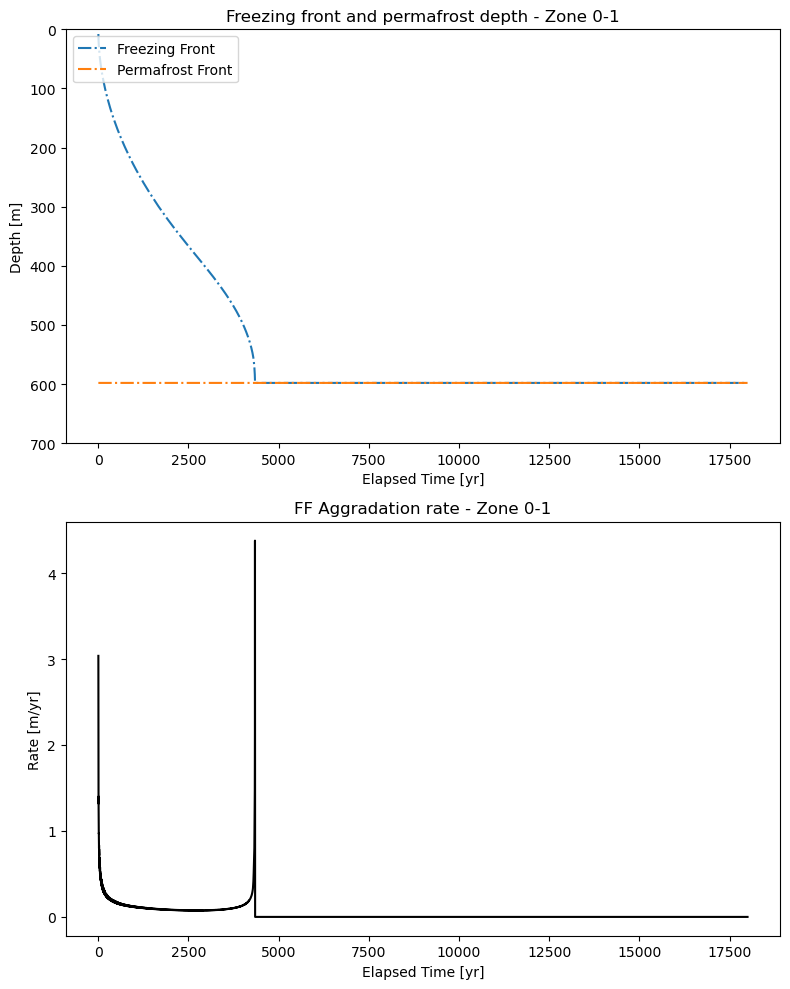

In [68]:
colcount = 1

for col in col_incl:
    if col==1:
        l = runtime  # Runtime [yr]
        k = 0
        zqFF = np.zeros(l)
        zq_1 = np.zeros(l)
        zqPF = np.zeros(l)
        temp = np.zeros((nocell, l))
        tt = np.arange(1, l + 1, t_intv)
        tt_shift = np.arange(1, l, t_intv)
        aggr_rateFF = np.zeros(l-1)
        aggr_rate_1 = np.zeros(l-1)
        aggr_ratePF = np.zeros(l-1)

        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx

            transposed_temp = np.transpose(temp[0:nocell_1, k-1]) # Switches rows and columns
            interp_func = interp1d(transposed_temp, z[0:nocell_1], kind='linear')
            
            if TqFF < np.min(transposed_temp) or TqFF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqFF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqFF)

            zqFF[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx
            
            if Tq_1 < np.min(transposed_temp) or Tq_1 > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(Tq_1, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(Tq_1)


            zq_1[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx
            
            if TqPF < np.min(transposed_temp) or TqPF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqPF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqPF)

            zqPF[i] = interpolated_value

        colcount += 1
        presentFFdepth[colcount]=zqFF[len(zqFF)-1]
        presentPFdepth[colcount]=zqPF[len(zqPF)-1]
        DtoDF[colcount]=Dcol1

        no_points = len(zqFF)
        tt_shifted = tt - 0.5 * t_intv
        tt_shift[0:(no_points - 1)] = tt_shifted[1:no_points]
        tt_shift_BP = np.flip(tt_shift)
        tt_flip = np.flip(tt)

        for ii in range(len(zqFF)-1):
            aggr_rateFF[ii] = (zqFF[ii + 1] - zqFF[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_rate_1[ii] = (zq_1[ii + 1] - zq_1[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_ratePF[ii] = (zqPF[ii + 1] - zqPF[ii]) / t_intv

        presentAggrRate[colcount]=aggr_rateFF[len(aggr_rateFF)-1]

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Plot the Freezing front and PF depth data in the first subplot
axes[0].plot(tt, zqFF, '-.', label='Freezing Front')
axes[0].plot(tt, zqPF, '-.', label='Permafrost Front')
axes[0].set_title('Freezing front and permafrost depth - Zone 0-1')
axes[0].invert_yaxis()
axes[0].set_xlabel('Elapsed Time [yr]')
axes[0].set_ylabel('Depth [m]')
axes[0].legend(loc='upper left')
axes[0].set_ylim(grid_depth+100, 0)

# Plot the Aggradation rate data in the second subplot
axes[1].plot(tt_shift, aggr_rateFF, 'k')
axes[1].set_title('FF Aggradation rate - Zone 0-1')
axes[1].set_xlabel('Elapsed Time [yr]')
axes[1].set_ylabel('Rate [m/yr]')
#axes[1].legend(loc='upper right')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [ ]:
#current problem: no permafrost aggradation
#this is bc zq_1 and zqPF don't change at all. I think this is still an interpolation issue.
#maybe not a problem—I think we only have to track the freezing front

In [ ]:
print(zqFF)

In [ ]:
print(zqPF)

## Final PF and FF depths

In [ ]:
plt.plot(DtoDF, presentFFdepth, c='blue', label='Final FF Depth')
plt.plot(DtoDF, presentPFdepth, c='red', label='Final PF Depth')
plt.xlabel('Distance to delta front [m]')
plt.ylabel('Depth [m]')
plt.title('Permafrost and freezing front depths')
plt.gca().invert_yaxis()
plt.legend(loc='upper right')

## Final Aggradation Rate and Recharge Equivalent

In [ ]:
plt.plot(DtoDF[2:], presentAggrRate[2:], c='blue')
plt.xlabel('Distance to delta front [m]')
plt.ylabel('Rate [m/yr]')
plt.title('Aggradation rate and recharge equivalent')

In [ ]:
# next steps: add in temp-dependent material properties? play with diff layers? Investigate FF and PF depths 

## Playing around with the densification of material

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants for Earth
solid_density = 1300  # Solid density of the material in kg/m^3
initial_porosity = 0.33  # Initial porosity at the surface
earth_gravity = 9.81  # Acceleration due to gravity on Earth in m/s^2

# Constants for another planet
new_gravity = 0.27  # Acceleration due to gravity on Ceres in m/s^2

# Depth range
depths = np.linspace(0, 1000, 10)  # Depth values in meters

# Calculate density at different depths for Earth
densities_earth = solid_density * (1 - (initial_porosity * np.exp(-depths / 10)))

# Calculate density at different depths for the other planet
densities_new_planet = solid_density * (1 - (initial_porosity * np.exp(-depths / 10))) * (earth_gravity / new_gravity)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(densities_earth, depths, 'b-', label='Earth Density Profile')
plt.plot(densities_new_planet, depths, 'r-', label='Other Planet Density Profile')
plt.xlabel('Density (kg/m^3)')
plt.ylabel('Depth (m)')
plt.title('Density Profile vs. Depth')
plt.legend()
plt.grid()
plt.show()


## Plotting Final Effective Material Properties 

In [69]:
print(a_eq_0_1)

[ 0.         36.68309706 24.90143916 24.90143916 24.90143916 24.90143916
 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916
 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916
 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916
 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916
 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916
 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916
 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916
 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916
 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916
 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916
 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916
 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916 24.90143916
 24.90143916 24.90143916 24.90143916 24.90143916 24

In [70]:
print(C_eq_0_1)

[      0.   1925700.   1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66
 1975479.66 1975479.66 1975479.66 1975479.66 1975479.66 197547

In [ ]:
F_w_0_1

In [ ]:
F_ice_0_1